# Social Network Analysis: All Connections

This notebook analyzes the soc-Pokec dataset using **all connections** (full undirected graph).

## Graph Type
- **Full Undirected Graph**: All directed edges converted to undirected
- An edge exists if A follows B OR B follows A (or both)
- More inclusive but includes one-way "follower" relationships

## Step 1: Setup and Data Loading

In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import time
import random
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        plt.style.use('ggplot')

sns.set_palette('husl')

DATA_DIR = Path('data')
OUTPUTS_DIR = Path('outputs')
OUTPUTS_DIR.mkdir(exist_ok=True)

def get_memory_usage():
    """Return current memory usage in GB."""
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 3)

print(f"Initial memory usage: {get_memory_usage():.2f} GB")

Initial memory usage: 0.23 GB


In [2]:
# Load directed graph
print("Loading directed edge list...")
start_time = time.time()

edges_file = DATA_DIR / 'soc-pokec-relationships.txt'
G_directed = nx.read_edgelist(str(edges_file), create_using=nx.DiGraph(), nodetype=int)

load_time = time.time() - start_time
print(f"Loaded in {load_time:.2f} seconds")
print(f"Directed Graph - Nodes: {G_directed.number_of_nodes():,}, Edges: {G_directed.number_of_edges():,}")
print(f"Memory usage: {get_memory_usage():.2f} GB")

Loading directed edge list...
Loaded in 55.70 seconds
Directed Graph - Nodes: 1,632,803, Edges: 30,622,564
Memory usage: 6.76 GB


In [3]:
# Convert to FULL undirected graph (all edges)
print("Converting to full undirected graph...")
start_time = time.time()

G_undirected = G_directed.to_undirected()

conversion_time = time.time() - start_time
print(f"Full Undirected Graph - Nodes: {G_undirected.number_of_nodes():,}, Edges: {G_undirected.number_of_edges():,}")
print(f"Converted in {conversion_time:.2f} seconds")

# Compute reciprocity for reference
reciprocity = nx.reciprocity(G_directed)
print(f"\nNetwork Reciprocity: {reciprocity:.4f} ({reciprocity*100:.2f}%)")
print(f"  - {reciprocity*100:.1f}% of directed edges are reciprocated")
print(f"  - {(1-reciprocity)*100:.1f}% are one-way connections (included in this graph)")

print(f"\nMemory usage: {get_memory_usage():.2f} GB")

Converting to full undirected graph...
Full Undirected Graph - Nodes: 1,632,803, Edges: 22,301,964
Converted in 56.05 seconds

Network Reciprocity: 0.5434 (54.34%)
  - 54.3% of directed edges are reciprocated
  - 45.7% are one-way connections (included in this graph)

Memory usage: 13.50 GB


In [4]:
# Free memory - remove directed graph
print("Freeing memory by removing directed graph...")
del G_directed
import gc
gc.collect()
print(f"Memory usage after cleanup: {get_memory_usage():.2f} GB")

Freeing memory by removing directed graph...
Memory usage after cleanup: 11.45 GB


## Step 2: Connected Component Analysis

In [5]:
# Get the largest connected component
print("Analyzing connected components...")
start_time = time.time()

largest_cc = max(nx.connected_components(G_undirected), key=len)
num_components = nx.number_connected_components(G_undirected)

print(f"Number of connected components: {num_components:,}")
print(f"Largest component: {len(largest_cc):,} nodes ({100*len(largest_cc)/G_undirected.number_of_nodes():.2f}%)")

# Create subgraph of largest component
G = G_undirected.subgraph(largest_cc).copy()

# Free memory
del G_undirected, largest_cc
gc.collect()

print(f"\nWorking graph (LCC) - Nodes: {G.number_of_nodes():,}, Edges: {G.number_of_edges():,}")
print(f"Component analysis completed in {time.time() - start_time:.2f} seconds")
print(f"Memory usage: {get_memory_usage():.2f} GB")

Analyzing connected components...
Number of connected components: 1
Largest component: 1,632,803 nodes (100.00%)

Working graph (LCC) - Nodes: 1,632,803, Edges: 22,301,964
Component analysis completed in 95.64 seconds
Memory usage: 9.93 GB


## Step 3: Degrees of Separation Analysis

In [6]:
# Sample and compute shortest paths
print("="*60)
print("DEGREES OF SEPARATION ANALYSIS - FULL GRAPH")
print("="*60)

NUM_SAMPLES = 10000
random.seed(42)

nodes_list = list(G.nodes())
path_lengths = []
failed_paths = 0
start_time = time.time()

sample_pairs = [(random.choice(nodes_list), random.choice(nodes_list)) for _ in range(NUM_SAMPLES)]

for i, (src, tgt) in enumerate(sample_pairs):
    if src == tgt:
        continue
    try:
        length = nx.shortest_path_length(G, src, tgt)
        path_lengths.append(length)
    except nx.NetworkXNoPath:
        failed_paths += 1
    
    if (i + 1) % 2500 == 0:
        print(f"Progress: {i+1}/{NUM_SAMPLES}")

compute_time = time.time() - start_time
print(f"\nCompleted in {compute_time:.2f}s")
print(f"Paths found: {len(path_lengths):,} | Failed: {failed_paths}")

DEGREES OF SEPARATION ANALYSIS - FULL GRAPH
Progress: 2500/10000
Progress: 5000/10000
Progress: 7500/10000
Progress: 10000/10000

Completed in 3.57s
Paths found: 10,000 | Failed: 0


In [7]:
# Calculate statistics
avg_degree_sep = np.mean(path_lengths)
median_degree_sep = np.median(path_lengths)
std_degree_sep = np.std(path_lengths)
min_degree_sep = min(path_lengths)
max_degree_sep = max(path_lengths)

print("\n" + "="*60)
print("DEGREES OF SEPARATION RESULTS (FULL GRAPH)")
print("="*60)
print(f"Average degrees of separation: {avg_degree_sep:.2f}")
print(f"Median degrees of separation: {median_degree_sep:.2f}")
print(f"Standard deviation: {std_degree_sep:.2f}")
print(f"Min path length: {min_degree_sep}")
print(f"Max path length: {max_degree_sep}")

print(f"\n{'Six Degrees of Separation':}")
if avg_degree_sep <= 6:
    print(f"   ✅ CONFIRMED! Average is {avg_degree_sep:.2f} degrees")
else:
    print(f"   ❌ NOT confirmed. Average is {avg_degree_sep:.2f} degrees")

# Distribution
print(f"\nPath Length Distribution:")
distribution = Counter(path_lengths)
for length in sorted(distribution.keys()):
    count = distribution[length]
    pct = 100 * count / len(path_lengths)
    bar = '█' * int(pct / 2)
    print(f"  {length}: {count:,} ({pct:.1f}%) {bar}")


DEGREES OF SEPARATION RESULTS (FULL GRAPH)
Average degrees of separation: 4.70
Median degrees of separation: 5.00
Standard deviation: 0.80
Min path length: 2
Max path length: 9

Six Degrees of Separation
   ✅ CONFIRMED! Average is 4.70 degrees

Path Length Distribution:
  2: 13 (0.1%) 
  3: 407 (4.1%) ██
  4: 3,692 (36.9%) ██████████████████
  5: 4,485 (44.9%) ██████████████████████
  6: 1,259 (12.6%) ██████
  7: 132 (1.3%) 
  8: 11 (0.1%) 
  9: 1 (0.0%) 


## Step 4: Network Metrics

In [8]:
# Compute network metrics
print("="*60)
print("NETWORK METRICS (FULL GRAPH)")
print("="*60)

degrees = [d for n, d in G.degree()]
avg_degree = np.mean(degrees)
density = nx.density(G)

print(f"\nBasic Metrics:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Average degree: {avg_degree:.2f}")
print(f"  Network density: {density:.6f}")

print(f"\nDegree Statistics:")
print(f"  Min degree: {min(degrees)}")
print(f"  Max degree: {max(degrees)}")
print(f"  Median degree: {np.median(degrees):.0f}")
print(f"  Std deviation: {np.std(degrees):.2f}")

NETWORK METRICS (FULL GRAPH)

Basic Metrics:
  Nodes: 1,632,803
  Edges: 22,301,964
  Average degree: 27.32
  Network density: 0.000017

Degree Statistics:
  Min degree: 1
  Max degree: 14854
  Median degree: 13
  Std deviation: 42.85


In [9]:
# Clustering coefficient (sampled)
print("\nComputing clustering coefficient (sampled)...")
sample_nodes = random.sample(list(G.nodes()), min(10000, G.number_of_nodes()))
clustering_coeffs = nx.clustering(G, nodes=sample_nodes)
avg_clustering = np.mean(list(clustering_coeffs.values()))

print(f"  Average clustering coefficient: {avg_clustering:.4f}")


Computing clustering coefficient (sampled)...
  Average clustering coefficient: 0.1066


## Step 5: Community Detection

In [10]:
import community as community_louvain

# BFS sampling for community detection
COMMUNITY_SAMPLE_SIZE = 50000

def bfs_sample(G, start_node, max_nodes):
    """Sample a connected subgraph using BFS from a start node."""
    visited = set()
    queue = [start_node]
    visited.add(start_node)
    
    while queue and len(visited) < max_nodes:
        node = queue.pop(0)
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= max_nodes:
                    break
    return visited

print(f"Creating connected sample using BFS...")

# Start from a high-degree node
degrees_dict = dict(G.degree())
start_node = max(degrees_dict, key=degrees_dict.get)
print(f"Starting BFS from node {start_node} (degree: {degrees_dict[start_node]})")

sample_nodes_community = bfs_sample(G, start_node, COMMUNITY_SAMPLE_SIZE)
G_sample = G.subgraph(sample_nodes_community).copy()

print(f"Sample graph - Nodes: {G_sample.number_of_nodes():,}, Edges: {G_sample.number_of_edges():,}")

Creating connected sample using BFS...
Starting BFS from node 5935 (degree: 14854)
Sample graph - Nodes: 50,000, Edges: 431,029


In [11]:
# Run Louvain community detection
print("Running Louvain community detection...")
start_time = time.time()

partition = community_louvain.best_partition(G_sample, random_state=42)
modularity = community_louvain.modularity(partition, G_sample)

community_time = time.time() - start_time
print(f"Completed in {community_time:.2f} seconds")

# Analyze communities
community_sizes = Counter(partition.values())
num_communities = len(community_sizes)

print(f"\n{'='*60}")
print("COMMUNITY DETECTION RESULTS (FULL GRAPH)")
print(f"{'='*60}")
print(f"Number of communities: {num_communities}")
print(f"Modularity score: {modularity:.4f}")
print(f"\nTop 10 largest communities:")
for i, (comm_id, size) in enumerate(community_sizes.most_common(10)):
    pct = 100 * size / G_sample.number_of_nodes()
    print(f"  Community {comm_id}: {size:,} nodes ({pct:.1f}%)")

sizes = list(community_sizes.values())
print(f"\nCommunity size statistics:")
print(f"  Average: {np.mean(sizes):.1f} nodes")
print(f"  Median: {np.median(sizes):.1f} nodes")
print(f"  Largest: {max(sizes):,} nodes")
print(f"  Smallest: {min(sizes)} nodes")

Running Louvain community detection...
Completed in 9.58 seconds

COMMUNITY DETECTION RESULTS (FULL GRAPH)
Number of communities: 23
Modularity score: 0.7224

Top 10 largest communities:
  Community 6: 6,774 nodes (13.5%)
  Community 1: 5,170 nodes (10.3%)
  Community 7: 3,774 nodes (7.5%)
  Community 16: 3,414 nodes (6.8%)
  Community 3: 3,097 nodes (6.2%)
  Community 2: 2,868 nodes (5.7%)
  Community 4: 2,807 nodes (5.6%)
  Community 13: 2,758 nodes (5.5%)
  Community 11: 2,510 nodes (5.0%)
  Community 9: 2,480 nodes (5.0%)

Community size statistics:
  Average: 2173.9 nodes
  Median: 2383.0 nodes
  Largest: 6,774 nodes
  Smallest: 57 nodes


## Step 6: Centrality Analysis

In [12]:
# Centrality analysis on sample
print("="*60)
print("CENTRALITY ANALYSIS (FULL GRAPH)")
print("="*60)

CENTRALITY_SAMPLE = 10000
if G_sample.number_of_nodes() > CENTRALITY_SAMPLE:
    centrality_nodes = bfs_sample(G_sample, start_node, CENTRALITY_SAMPLE)
    G_centrality = G_sample.subgraph(centrality_nodes).copy()
else:
    G_centrality = G_sample

print(f"Computing centrality on {G_centrality.number_of_nodes():,} nodes...")

# Degree centrality
print("\nDegree Centrality:")
degree_centrality = nx.degree_centrality(G_centrality)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("  Top 10 nodes:")
for node, cent in top_degree:
    print(f"    Node {node}: {cent:.4f} (degree: {G_centrality.degree(node)})")

CENTRALITY ANALYSIS (FULL GRAPH)
Computing centrality on 10,000 nodes...

Degree Centrality:
  Top 10 nodes:
    Node 5935: 1.0000 (degree: 9999)
    Node 25855: 0.0196 (degree: 196)
    Node 34032: 0.0060 (degree: 60)
    Node 67915: 0.0059 (degree: 59)
    Node 140549: 0.0040 (degree: 40)
    Node 73051: 0.0035 (degree: 35)
    Node 91214: 0.0035 (degree: 35)
    Node 160692: 0.0035 (degree: 35)
    Node 78617: 0.0030 (degree: 30)
    Node 289280: 0.0030 (degree: 30)


In [13]:
# Betweenness centrality (sampled)
print("\nBetweenness Centrality (sampled):")
start_time = time.time()
betweenness = nx.betweenness_centrality(G_centrality, k=min(500, G_centrality.number_of_nodes()))
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"  Computed in {time.time() - start_time:.2f}s")
print("  Top 10 nodes:")
for node, cent in top_betweenness:
    print(f"    Node {node}: {cent:.6f}")


Betweenness Centrality (sampled):
  Computed in 22.96s
  Top 10 nodes:
    Node 5935: 0.998643
    Node 25855: 0.000136
    Node 34032: 0.000023
    Node 67915: 0.000023
    Node 76: 0.000014
    Node 91214: 0.000009
    Node 55597: 0.000008
    Node 39244: 0.000007
    Node 88001: 0.000007
    Node 73051: 0.000006


In [14]:
# PageRank
print("\nPageRank:")
start_time = time.time()
pagerank = nx.pagerank(G_sample, alpha=0.85, max_iter=100)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"  Computed in {time.time() - start_time:.2f}s")
print("  Top 10 nodes:")
for node, score in top_pagerank:
    print(f"    Node {node}: {score:.6f}")


PageRank:
  Computed in 0.37s
  Top 10 nodes:
    Node 5935: 0.022191
    Node 5867: 0.001682
    Node 1891: 0.001547
    Node 25855: 0.001453
    Node 6228: 0.001095
    Node 76: 0.001044
    Node 25994: 0.001005
    Node 48826: 0.000924
    Node 189: 0.000739
    Node 1830: 0.000586


## Step 7: Link Prediction

In [15]:
# Create sample for link prediction
LINK_PRED_SAMPLE = 5000

print(f"Creating sample for link prediction...")
sample_nodes_lp = bfs_sample(G, start_node, LINK_PRED_SAMPLE)
G_lp = G.subgraph(sample_nodes_lp).copy()

print(f"Link prediction sample - Nodes: {G_lp.number_of_nodes():,}, Edges: {G_lp.number_of_edges():,}")

# Generate non-edges
print("Generating candidate pairs...")
existing_edges = set(G_lp.edges())
lp_nodes = list(G_lp.nodes())

non_edges = []
high_degree_nodes = [n for n in lp_nodes if G_lp.degree(n) >= 3]

attempts = 0
while len(non_edges) < 1000 and attempts < 50000:
    if len(high_degree_nodes) >= 2:
        u, v = random.sample(high_degree_nodes, 2)
    else:
        u, v = random.sample(lp_nodes, 2)
    
    if (u, v) not in existing_edges and (v, u) not in existing_edges and u != v:
        common = len(set(G_lp.neighbors(u)) & set(G_lp.neighbors(v)))
        if common > 0 or attempts > 25000:
            non_edges.append((u, v))
    attempts += 1

print(f"Generated {len(non_edges)} non-edge pairs")

Creating sample for link prediction...
Link prediction sample - Nodes: 5,000, Edges: 9,754
Generating candidate pairs...
Generated 1000 non-edge pairs


In [16]:
# Link prediction methods
print("\nJaccard Coefficient - Top 10 predictions:")
jaccard_preds = sorted(nx.jaccard_coefficient(G_lp, non_edges), key=lambda x: x[2], reverse=True)[:10]
for u, v, score in jaccard_preds:
    print(f"  ({u}, {v}): {score:.4f}")

print("\nAdamic-Adar Index - Top 10 predictions:")
aa_preds = sorted(nx.adamic_adar_index(G_lp, non_edges), key=lambda x: x[2], reverse=True)[:10]
for u, v, score in aa_preds:
    print(f"  ({u}, {v}): {score:.4f}")


Jaccard Coefficient - Top 10 predictions:
  (78769, 153798): 0.4000
  (221829, 229790): 0.3333
  (72307, 236362): 0.2000
  (232282, 217724): 0.2000
  (32454, 255860): 0.2000
  (229587, 246158): 0.2000
  (24726, 134051): 0.2000
  (79516, 236581): 0.2000
  (223354, 254334): 0.2000
  (254069, 247448): 0.2000

Adamic-Adar Index - Top 10 predictions:
  (221829, 229790): 1.0277
  (113349, 217256): 0.6755
  (255163, 220977): 0.5983
  (78769, 153798): 0.4512
  (197976, 222330): 0.1174
  (222330, 84138): 0.1174
  (197679, 252190): 0.1174
  (72307, 236362): 0.1174
  (231944, 242239): 0.1174
  (6107, 44108): 0.1174


## Step 8: Visualizations

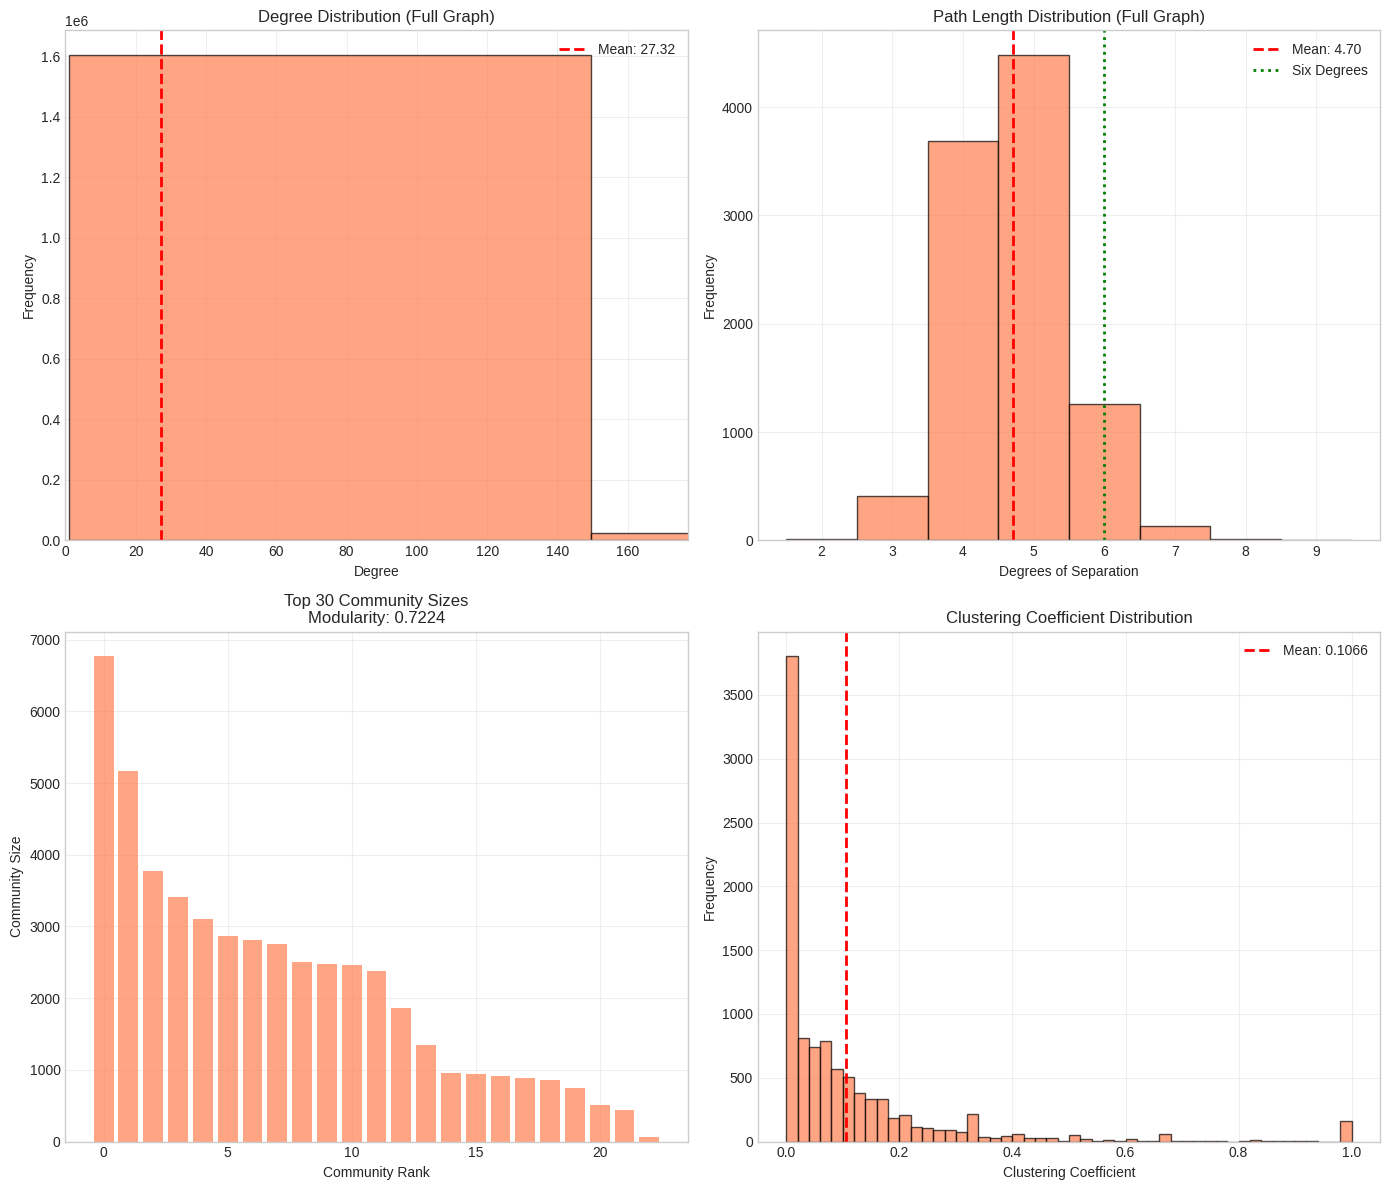

Figure saved to outputs/all_connections_analysis.png


In [17]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Degree distribution
ax1 = axes[0, 0]
ax1.hist(degrees, bins=100, alpha=0.7, color='coral', edgecolor='black')
ax1.axvline(avg_degree, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_degree:.2f}')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Degree Distribution (Full Graph)')
ax1.set_xlim(0, np.percentile(degrees, 99))
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Path length distribution
ax2 = axes[0, 1]
bins = range(min(path_lengths), max(path_lengths) + 2)
ax2.hist(path_lengths, bins=bins, alpha=0.7, color='coral', edgecolor='black', align='left')
ax2.axvline(avg_degree_sep, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_degree_sep:.2f}')
ax2.axvline(6, color='green', linestyle=':', linewidth=2, label='Six Degrees')
ax2.set_xlabel('Degrees of Separation')
ax2.set_ylabel('Frequency')
ax2.set_title('Path Length Distribution (Full Graph)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Community size distribution
ax3 = axes[1, 0]
sizes_sorted = sorted(sizes, reverse=True)
ax3.bar(range(min(30, len(sizes_sorted))), sizes_sorted[:30], color='coral', alpha=0.7)
ax3.set_xlabel('Community Rank')
ax3.set_ylabel('Community Size')
ax3.set_title(f'Top 30 Community Sizes\nModularity: {modularity:.4f}')
ax3.grid(True, alpha=0.3)

# 4. Clustering coefficient distribution
ax4 = axes[1, 1]
clustering_values = list(clustering_coeffs.values())
ax4.hist(clustering_values, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax4.axvline(avg_clustering, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_clustering:.4f}')
ax4.set_xlabel('Clustering Coefficient')
ax4.set_ylabel('Frequency')
ax4.set_title('Clustering Coefficient Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'all_connections_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure saved to {OUTPUTS_DIR / 'all_connections_analysis.png'}")

## Final Summary

In [18]:
print("="*70)
print("ALL CONNECTIONS ANALYSIS - FINAL SUMMARY")
print("="*70)

print(f"\n📁 DATASET: Pokec Social Network (All Connections)")
print(f"   Graph type: Full undirected (all edges)")
print(f"   Network reciprocity: {reciprocity:.4f} ({reciprocity*100:.1f}%)")
print(f"   Note: Includes {(1-reciprocity)*100:.1f}% one-way connections")

print(f"\n📊 GRAPH STATISTICS:")
print(f"   Nodes in LCC: {G.number_of_nodes():,}")
print(f"   Edges in LCC: {G.number_of_edges():,}")
print(f"   Average degree: {avg_degree:.2f}")
print(f"   Network density: {density:.6f}")
print(f"   Average clustering: {avg_clustering:.4f}")

print(f"\n🎯 SIX DEGREES OF SEPARATION:")
if avg_degree_sep <= 6:
    print(f"   ✅ CONFIRMED!")
else:
    print(f"   ❌ NOT confirmed")
print(f"   Average: {avg_degree_sep:.2f} degrees")
print(f"   Median: {median_degree_sep:.1f} degrees")

print(f"\n👥 COMMUNITY STRUCTURE:")
print(f"   Communities detected: {num_communities}")
print(f"   Modularity: {modularity:.4f}")
print(f"   Largest community: {max(sizes):,} nodes")

print(f"\n💡 KEY INSIGHTS:")
print(f"   1. Full graph includes ALL connections (mutual + one-way)")
print(f"   2. Higher average degree ({avg_degree:.2f}) than mutual-only graph")
print(f"   3. Shorter path lengths due to more edges")
print(f"   4. Six degrees hypothesis {'confirmed' if avg_degree_sep <= 6 else 'not confirmed'}")

print(f"\n{'='*70}")
print(f"Memory usage: {get_memory_usage():.2f} GB")

ALL CONNECTIONS ANALYSIS - FINAL SUMMARY

📁 DATASET: Pokec Social Network (All Connections)
   Graph type: Full undirected (all edges)
   Network reciprocity: 0.5434 (54.3%)
   Note: Includes 45.7% one-way connections

📊 GRAPH STATISTICS:
   Nodes in LCC: 1,632,803
   Edges in LCC: 22,301,964
   Average degree: 27.32
   Network density: 0.000017
   Average clustering: 0.1066

🎯 SIX DEGREES OF SEPARATION:
   ✅ CONFIRMED!
   Average: 4.70 degrees
   Median: 5.0 degrees

👥 COMMUNITY STRUCTURE:
   Communities detected: 23
   Modularity: 0.7224
   Largest community: 6,774 nodes

💡 KEY INSIGHTS:
   1. Full graph includes ALL connections (mutual + one-way)
   2. Higher average degree (27.32) than mutual-only graph
   3. Shorter path lengths due to more edges
   4. Six degrees hypothesis confirmed

Memory usage: 9.93 GB
